In this file I check if learning to map from full rank data to low rank data is a meaningful approach.

I do this by computing the following:

I estimate signal with:
    
    groundtruth_1 := Fully sampled Patient 1

    signal ~ LowRank8(groundtruth_1)
    
    noise ~ shuffling of last 30 FID time steps from different patients ~ 96 in total
    
    groundtruth_2 = signal + noise
    
    Undersampled := undersampled groundtruth_1 (exact same noise)
    
The most reasonable bound on errors is: 

    ||LowRank(groundtruth_1)-LowRank(groundtruth_2)||
if:    
    
    ||LowRank(Undersampled) - LowRank(groundtruth_1)|| < ||LowRank(groundtruth_1)-LowRank(groundtruth_2)||
    
The best the network can hope is learning low rank directly, similar to how it learned IFFT directly;
This will go below the reasonable error threshold by exploiting the reamaining noise that 
 


In [2]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

MASKS = np.load('../data/masks.npy')
noise = np.concatenate([Ground_Truth[:,:,:,65:95,:,1], Ground_Truth[:,:,:,65:95,:,2], Ground_Truth[:,:,:,65:95,:,3], Ground_Truth[:,:,:,89:95,:,4]], axis=3)  
grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

# ***Possoin undersampling***

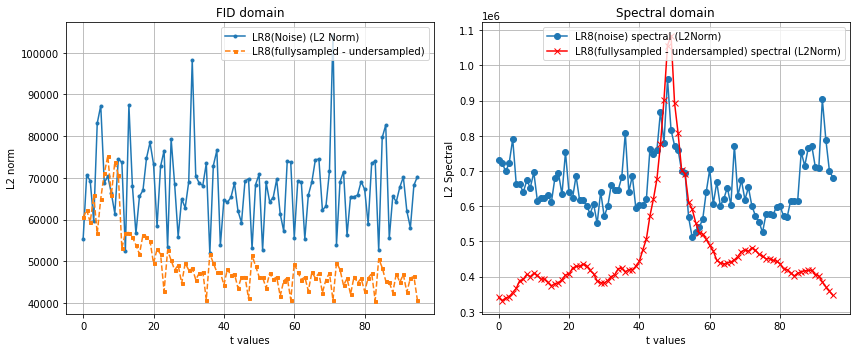

In [10]:
trancuate_t = 96
Patient = 0
AF = 3

Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
    
#noise = Ground_Truth[...,Patient]-low_rank(Undersampled_Data[..., Patient], 8)
noise = np.concatenate([Ground_Truth[:,:,:,65:95,:,1], Ground_Truth[:,:,:,65:95,:,2], Ground_Truth[:,:,:,65:95,:,3], Ground_Truth[:,:,:,89:95,:,4]], axis=3)  
  
axis_to_shuffle = 3
shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)
 
LR8_noise = low_rank(noise, 8)
LR8_undersampling_error = low_rank(Ground_Truth[..., Patient]-Undersampled_Data[..., Patient], 8)

#### Also spectral domain
LR8_noise_spectral = np.fft.fftshift(np.fft.fft(LR8_noise, axis=-2), axes = -2)
LR8_undersampling_error_spectral = np.fft.fftshift(np.fft.fft(LR8_undersampling_error, axis=-2), axes = -2)

#### Compute 2 Norm of 3D volumes
LR8_noise_L2 = np.sqrt(np.sum(np.abs(LR8_noise)**2, axis=(0,1,2)))
LR8_undersampling_error_L2 = np.sqrt(np.sum(np.abs(LR8_undersampling_error)**2, axis=(0,1,2)))

LR8_noise_spectral_L2 = np.sqrt(np.sum(np.abs(LR8_noise_spectral)**2, axis=(0,1,2)))
LR8_undersampling_error_spectral_L2 = np.sqrt(np.sum(np.abs(LR8_undersampling_error_spectral)**2, axis=(0,1,2)))

#### Average over T
LR8_noise_L2 = np.mean(LR8_noise_L2, axis = -1)
LR8_undersampling_error_L2 = np.mean(LR8_undersampling_error_L2, axis = -1)

LR8_noise_spectral_L2 = np.mean(LR8_noise_spectral_L2, axis = -1)
LR8_undersampling_error_spectral_L2 = np.mean(LR8_undersampling_error_spectral_L2, axis = -1)

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Left subplot: Original two arrays
axes[0].plot(LR8_noise_L2, label='LR8(Noise) (L2 Norm)', linestyle='-', marker='o', markersize=3)
axes[0].plot(LR8_undersampling_error_L2, label='LR8(fullysampled - undersampled)', linestyle='--', marker='s', markersize=3)
axes[0].set_xlabel("t values")
axes[0].set_ylabel("L2 norm")
axes[0].set_title("FID domain")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Difference (Noise - Undersampling Error)
axes[1].plot(LR8_noise_spectral_L2, label='LR8(noise) spectral (L2Norm)', linestyle='-', marker='o')
axes[1].plot(LR8_undersampling_error_spectral_L2, label='LR8(fullysampled - undersampled) spectral (L2Norm)', linestyle='-', marker='x', color='r')
axes[1].set_xlabel("t values")
axes[1].set_ylabel("L2 Spectral")
axes[1].set_title("Spectral domain")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# **Regular Undersampling**

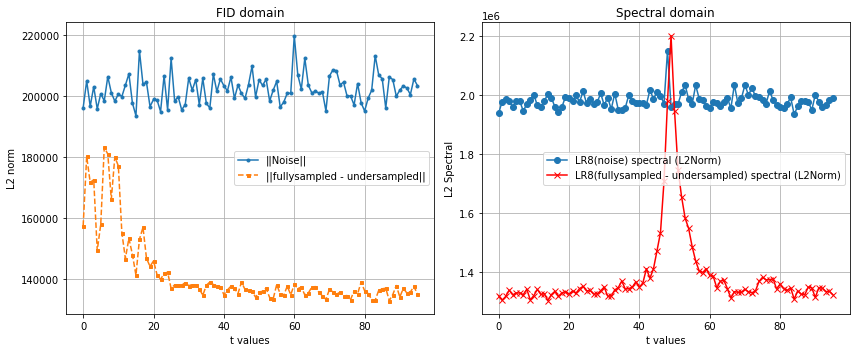

In [13]:
Dataset = 'FullRank' # Options: FullRank, SpectralFit, LowRank
trancuate_t = 96
Patient = 0
AF = 3

Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular.npy')
#noise = Ground_Truth[...,Patient]-low_rank(Undersampled_Data[..., Patient], 8)
#noise = Ground_Truth[...,Patient]-low_rank(Undersampled_Data[..., Patient], 8)
noise = np.concatenate([Ground_Truth[:,:,:,65:95,:,1], Ground_Truth[:,:,:,65:95,:,2], Ground_Truth[:,:,:,65:95,:,3], Ground_Truth[:,:,:,89:95,:,4]], axis=3)  

axis_to_shuffle = 3
shuffled_indices = np.random.permutation(noise.shape[axis_to_shuffle])
noise = np.take(noise, shuffled_indices, axis=axis_to_shuffle)
 
LR8_noise = noise#low_rank(noise, 8)
LR8_undersampling_error = Ground_Truth[..., Patient]-Undersampled_Data[..., Patient]#low_rank(Ground_Truth[..., Patient]-Undersampled_Data[..., Patient], 8)

#### Also spectral domain
LR8_noise_spectral = np.fft.fftshift(np.fft.fft(LR8_noise, axis=-2), axes = -2)
LR8_undersampling_error_spectral = np.fft.fftshift(np.fft.fft(LR8_undersampling_error, axis=-2), axes = -2)

#### Compute 2 Norm of 3D volumes
LR8_noise_L2 = np.sqrt(np.sum(np.abs(LR8_noise)**2, axis=(0,1,2)))
LR8_undersampling_error_L2 = np.sqrt(np.sum(np.abs(LR8_undersampling_error)**2, axis=(0,1,2)))

LR8_noise_spectral_L2 = np.sqrt(np.sum(np.abs(LR8_noise_spectral)**2, axis=(0,1,2)))
LR8_undersampling_error_spectral_L2 = np.sqrt(np.sum(np.abs(LR8_undersampling_error_spectral)**2, axis=(0,1,2)))

#### Average over T
LR8_noise_L2 = np.mean(LR8_noise_L2, axis = -1)
LR8_undersampling_error_L2 = np.mean(LR8_undersampling_error_L2, axis = -1)

LR8_noise_spectral_L2 = np.mean(LR8_noise_spectral_L2, axis = -1)
LR8_undersampling_error_spectral_L2 = np.mean(LR8_undersampling_error_spectral_L2, axis = -1)

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Left subplot: Original two arrays
axes[0].plot(LR8_noise_L2, label='||Noise||', linestyle='-', marker='o', markersize=3)
axes[0].plot(LR8_undersampling_error_L2, label='||fullysampled - undersampled||', linestyle='--', marker='s', markersize=3)
axes[0].set_xlabel("t values")
axes[0].set_ylabel("L2 norm")
axes[0].set_title("FID domain")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Difference (Noise - Undersampling Error)
axes[1].plot(LR8_noise_spectral_L2, label='LR8(noise) spectral (L2Norm)', linestyle='-', marker='o')
axes[1].plot(LR8_undersampling_error_spectral_L2, label='LR8(fullysampled - undersampled) spectral (L2Norm)', linestyle='-', marker='x', color='r')
axes[1].set_xlabel("t values")
axes[1].set_ylabel("L2 Spectral")
axes[1].set_title("Spectral domain")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()